<h1>Prediction of ratings based on title of the book</h1>

In [1]:
import pandas as pd 
import numpy as np 
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt 
from sklearn.preprocessing import MinMaxScaler 
import nltk
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\myste\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h3>Loading the file</h3>

In [2]:
data = pd.read_csv(r"C:\Users\myste\Downloads\archive\book_data.csv") 

<h3>Putting the ratings in self-defined buckets</h3>

In [3]:
data.loc[(data['book_rating'] <= 5.0 ) & (data['book_rating'] >= 4.5 ), 'book_rating'] = 5.0
data.loc[(data['book_rating'] < 4.5 ) & (data['book_rating'] >= 3.7 ), 'book_rating'] = 4.0
data.loc[(data['book_rating'] < 3.7 ) & (data['book_rating'] >= 2.8 ), 'book_rating'] = 3.0
data.loc[(data['book_rating'] < 2.8 ) & (data['book_rating'] >= 1.8 ), 'book_rating'] = 2.0
data.loc[(data['book_rating'] < 1.8 ) & (data['book_rating'] >= 0.0 ), 'book_rating'] = 1.0
data

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.0,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.0,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.0,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.0,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.0,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...
...,...,...,...,...,...,...,...,...,...,...,...,...
54296,Howard Megdal,"In this fearless and half-crazy story, Howard ...",NaN,Hardcover,9.78161E+12,256 pages,3.0,27,9,Taking the Field: A Fan's Quest to Run the Tea...,Sports|Baseball|Sports and Games|Sports|Nonfic...,https://images.gr-assets.com/books/1312074392l...
54297,Howard Megdal,From the icons of the game to the players who ...,NaN,Hardcover,9.78006E+12,256 pages,4.0,34,5,"The Baseball Talmud: Koufax, Greenberg, and th...",Nonfiction|Sports and Games|Sports,https://images.gr-assets.com/books/1348841629l...
54298,Howard Megdal,NaN,NaN,Kindle Edition,NaN,NaN,3.0,32,3,"Wilpon's Folly - The Story of a Man, His Fortu...",Sports|Baseball|Abandoned,https://images.gr-assets.com/books/1394277097l...
54299,Mimi Baird|Eve Claxton,"Soon to be a major motion picture, from Brad P...",NaN,Hardcover,9.7808E+12,272 pages,4.0,867,187,He Wanted the Moon: The Madness and Medical Ge...,Nonfiction|Autobiography|Memoir|Biography|Psyc...,https://images.gr-assets.com/books/1403192135l...


In [4]:
books = data['book_title'].to_numpy()

<h3>A function for tokenizing the words and padding sentences</h3>

In [5]:
def feature_correction(books):
    #Tokenizes the words
    word_tokenizer = Tokenizer()
    word_tokenizer.fit_on_texts(books)
    vocab_length = len(word_tokenizer.word_index) + 1
    #Makes the tokens into vectors
    embedded_sentences = word_tokenizer.texts_to_sequences(books)
    word_count = lambda sentence: len(word_tokenize(sentence))
    #Finding the length of the longest vector
    longest_sentence = max(books, key=word_count)
    length_long_sentence = len(word_tokenize(longest_sentence))
    #Padding the senteces to be the sam length as the longest vector
    padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
    #Scaling the vectors
    scaled_sentences = MinMaxScaler() 
    padded_sentences = scaled_sentences.fit_transform(padded_sentences) 
    return padded_sentences , vocab_length, word_tokenizer, length_long_sentence

In [6]:
padded_sentences , vocab_length,  word_tokenizer, length_long_sentence = feature_correction(books)

In [7]:
buckets = data['book_rating'].to_numpy()

<h3>One Hot Encoding the ratings for better analysis</h3>

In [8]:
oneHotEncoded = np.zeros((len(buckets),5))
for index,label in enumerate(buckets):
    oneHotEncoded[index,int(label)-1] = 1
oneHotEncoded

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

<h3>Splitting the data into testing and training (20:80)</h3>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(padded_sentences, oneHotEncoded, test_size = 0.20, random_state = np.random)

<h3>Making a dictionary to use pretrained weights from the Glove 100d model</h3>

In [10]:
embeddings_dictionary = dict()
glove_file = open(r"C:\Users\myste\Downloads\glove.6B\glove.6B.100d.txt", encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [11]:
embedding_matrix = np.zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

<h3>Training the data using transfer learning using Neural Networks</h3>

In [12]:
from keras import regularizers
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(70, activation='softmax'))
model.add(Dense(5, activation='softmax'))

<h3>Choosing the optimizer and loss function for training and evaluation</h3>

In [13]:
import keras
opt = keras.optimizers.SGD(learning_rate = 0.001)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 58, 100)           3638600   
_________________________________________________________________
flatten (Flatten)            (None, 5800)              0         
_________________________________________________________________
dense (Dense)                (None, 70)                406070    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 355       
Total params: 4,045,025
Trainable params: 406,425
Non-trainable params: 3,638,600
_________________________________________________________________
None


In [14]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test),epochs=20, verbose=1)

Epoch 1/20
1358/1358 [==============================] - 7s 5ms/step - loss: 1.3398 - acc: 0.7975 - val_loss: 1.1371 - val_acc: 0.7966
Epoch 2/20
1358/1358 [==============================] - 7s 5ms/step - loss: 1.0146 - acc: 0.7975 - val_loss: 0.9231 - val_acc: 0.7966
Epoch 3/20
1358/1358 [==============================] - 6s 5ms/step - loss: 0.8673 - acc: 0.7975 - val_loss: 0.8271 - val_acc: 0.7966
Epoch 4/20
1358/1358 [==============================] - 6s 5ms/step - loss: 0.7989 - acc: 0.7975 - val_loss: 0.7801 - val_acc: 0.7966
Epoch 5/20
1358/1358 [==============================] - 6s 5ms/step - loss: 0.7637 - acc: 0.7975 - val_loss: 0.7543 - val_acc: 0.7966
Epoch 6/20
1358/1358 [==============================] - 6s 5ms/step - loss: 0.7432 - acc: 0.7975 - val_loss: 0.7384 - val_acc: 0.7966
Epoch 7/20
1358/1358 [==============================] - 7s 5ms/step - loss: 0.7298 - acc: 0.7975 - val_loss: 0.7275 - val_acc: 0.7966
Epoch 8/20
1358/1358 [==============================] - 6s 5ms

<h3>Plotting the graph for loss function</h3>

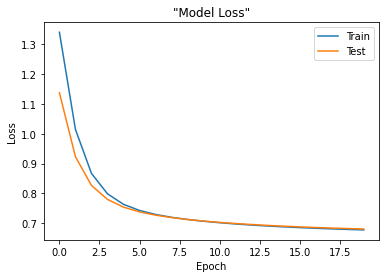

In [15]:
# loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('"Model Loss"')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

<h3>Predicting the rating of a self given title</h3>

In [16]:
x2 = word_tokenizer.texts_to_sequences(["The ghost stories of Egypt"])
new_sentences2 = pad_sequences(x2, length_long_sentence, padding='post')
new_sentences2

array([[   1,  218,   31,    2, 3267,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]])

In [17]:
what = model.predict(new_sentences2)
maxi = np.argmax(what)
if maxi == 4:
    print("Book rating will be between 4.5 to 5.0")
elif maxi == 3:
    print("Book rating will be between 3.7 to 4.4")
elif maxi == 2:
    print("Book rating will be between 3.6 to 2.8")
elif maxi == 1:
    print("Book rating will be between 2.7 to 1.8")
elif maxi == 0:
    print("Book rating will be between 1.7 to 0.0")

Book rating will be between 3.7 to 4.4


<h3>Finding the testing and training accuracies</h3>

In [18]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 79.661173


In [19]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 79.746777


<h2>Observations:</h2><br>
<p>1. The graph for the loss function for training and testing data shows that the datas have a similar loss rates and the shape of the graph suggests a good analysis using the proper learning rate, this shows a good fit.</p>
<p>2. Further analysis using the training and testing accuracy shows that the difference in accuracies is only 0.1% which further validates the above because this suggests the model is not under or overfit.</p>